In [1]:
%reset -f
%matplotlib inline

In [2]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import sebaba.ml as sbbml
import sebaba.utils as utils
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from scipy.stats import norm
from missingpy import KNNImputer

In [3]:
pd.options.display.float_format = "{:.4f}".format

In [4]:
df = pd.read_csv("data/house-prices/train.csv", sep = ",")
df = df.drop("Id", axis = 1)

In [5]:
utils.missing_var_pct(df)

PoolQC         99.5200
MiscFeature    96.3000
Alley          93.7700
Fence          80.7500
FireplaceQu    47.2600
LotFrontage    17.7400
GarageType      5.5500
GarageCond      5.5500
GarageFinish    5.5500
GarageQual      5.5500
GarageYrBlt     5.5500
BsmtFinType2    2.6000
BsmtExposure    2.6000
BsmtQual        2.5300
BsmtCond        2.5300
BsmtFinType1    2.5300
MasVnrArea      0.5500
MasVnrType      0.5500
Electrical      0.0700
dtype: float64


In [6]:
df = utils.drop_missing_var(df, threshold = 0.8)

In [7]:
df = df.drop("GarageYrBlt", axis = 1)
df = df.dropna(how = "any", subset = ["MasVnrType", "MasVnrArea", "Electrical"])

In [8]:
df.FireplaceQu = df.FireplaceQu.fillna("NoFirePlace")
basement       = ["BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual"]
df[basement]   = df[basement].fillna("NoBasement")
garage         = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
df[garage]     = df[garage].fillna("NoGarage")

In [9]:
df = df.dropna(how = "any", subset = ["MasVnrType", "MasVnrArea", "Electrical"])

In [10]:
imputer        = KNNImputer(n_neighbors = 5, weights = "distance", metric = "masked_euclidean")
df.LotFrontage = imputer.fit_transform(np.array(df.LotFrontage).reshape(-1, 1))

In [11]:
utils.missing_var_pct(df)

The dataframe has no missing values in any column.


In [12]:
#changing numeric variables to categorical
df.MSSubClass = ["SC" + str(i) for i in df.MSSubClass]
df.MoSold     = [calendar.month_abbr[i] for i in df.MoSold]

In [13]:
#converting cat variables to an interval scale as they are ordinal in nature
df = df.replace({
    "ExterQual"   : {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "ExterCond"   : {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtQual"    : {"NoBasement": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtCond"    : {"NoBasement": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtExposure": {"NoBasement": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
    "BsmtFinType1": {"NoBasement": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
    "BsmtFinType2": {"NoBasement": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
    "HeatingQC"   : {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "FireplaceQu" : {"NoFirePlace": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex" : 5},
    "GarageFinish": {"NoGarage": 0, "Unf": 1, "RFn": 2, "Fin": 3},
    "GarageQual"  : {"NoGarage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "GarageCond"  : {"NoGarage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
})

#creating a list of our ordinal variables
ordinal_vars = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure",
    "BsmtFinType1", "BsmtFinType2", "HeatingQC","KitchenQual", 
    "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond"
]

In [14]:
#changing features to their correct data types
df.BsmtCond     = df.BsmtCond.astype("int64")
df.BsmtFinType2 = df.BsmtFinType2.astype("int64")
df.FireplaceQu  = df.FireplaceQu.astype("int64")

In [15]:
#one hot encoding
#df = pd.get_dummies(df)
df["LogSalePrice"] = np.log(df.SalePrice)

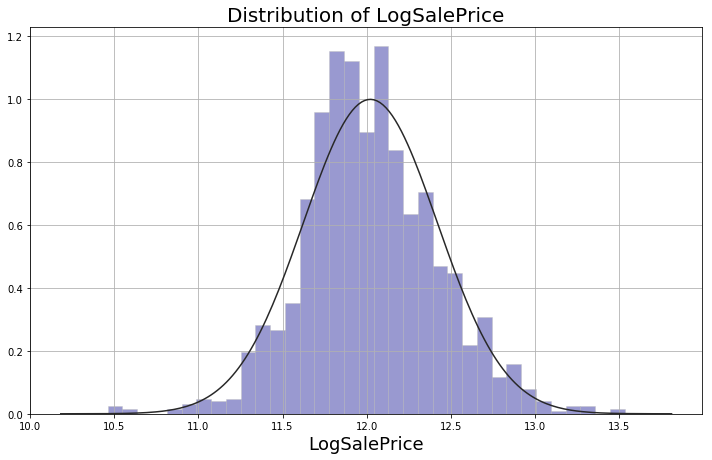

In [16]:
fig, ax = plt.subplots(figsize = (10.0, 6.5))
ax = sns.distplot(a = df.LogSalePrice, color = "darkblue", fit = norm, kde = False, hist_kws = {"edgecolor": "silver"})
ax.set_title("Distribution of LogSalePrice", fontsize = 20)
ax.set_xlabel("LogSalePrice", fontsize = 18)
ax.margins(0.05)
ax.axis("tight")
ax.grid(True)
fig.tight_layout()

plt.show()

In [17]:
num_df, cat_df = utils.split_numerical_categorical(df)

In [18]:
corr = num_df.corr()

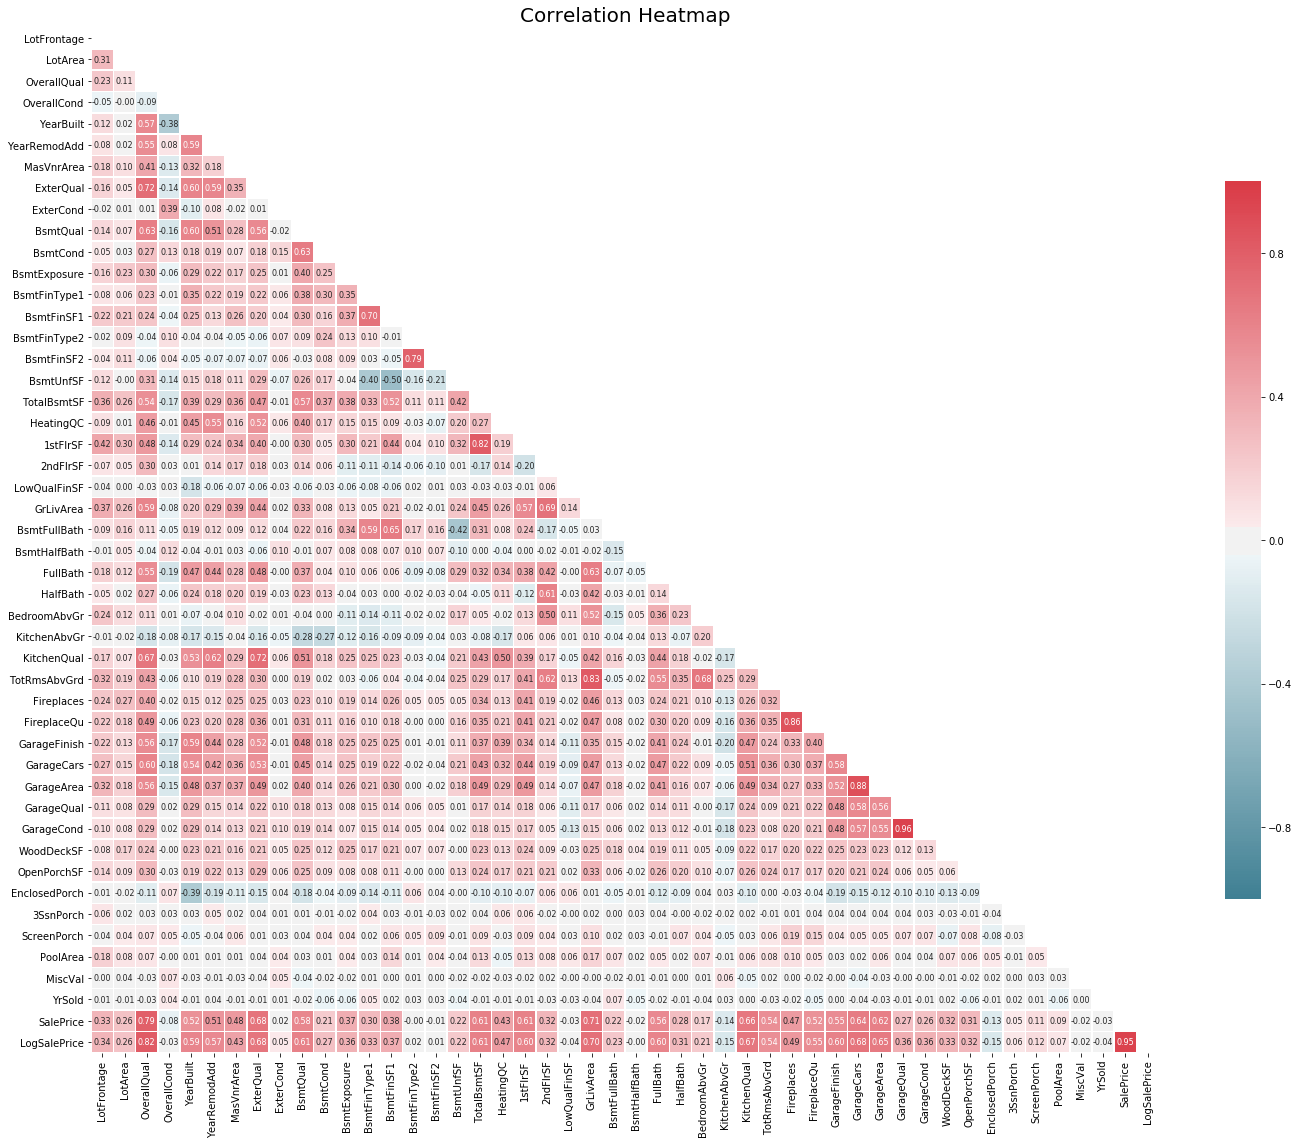

In [19]:
#generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap = True)

fig, ax = plt.subplots(figsize = (20, 16))
ax = sns.heatmap(corr, mask = mask, cmap = cmap, fmt = ".2f", vmin = -1, vmax = 1.0, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .7}, annot = True, annot_kws = {"size": 8})
ax.set_title("Correlation Heatmap", fontsize = 20)
ax.margins(0.05)
ax.axis("tight")
ax.grid(False)
fig.tight_layout()

plt.show()

In [20]:
y = num_df.LogSalePrice.values
x = num_df.drop(["SalePrice", "LogSalePrice"], axis = 1).values

In [21]:
x_train, x_test, y_train, y_test = utils.split_train_test(x, y, prop_train = 80.0)

In [22]:
opt_acc    = 0.0
alpha_list = np.arange(-10, 10, step = 0.02)

for alpha in alpha_list:
    model = sbbml.LinearRegression(alpha, iterations = 10000, normalize = True)
    model.fit(x_train, y_train)
    y_prime  = model.predict(x_test)
    curr_acc = utils.accuracy(y_prime, y_test)

    if curr_acc > opt_acc:
        print(curr_acc)

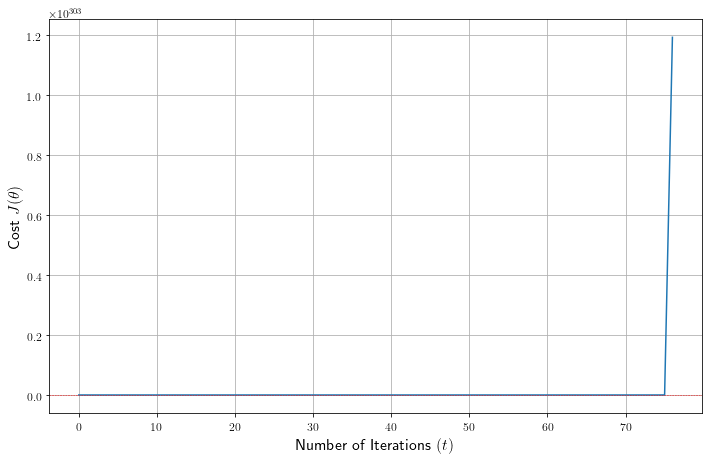

In [23]:
utils.plot_cost_function(cost = model.cost, width = 10.0, height = 6.5)